In [36]:
import numpy as np
import plotly as plt
from scipy.optimize import minimize
from tqdm import tqdm

In [12]:
eps = 0.0012   # Per share fee parameter
delta = 0.005   # tick size
gamma = 5 # inventory penelisation 
m = 6  # the number of states of the spread
n = 100 # grid of inventory
e = 100 # max volumne for market orders
T = 300 # timespan
dt = T / 100 # time difference for Euler scheme
l_max = 100 # maximum volume of an ordinary order
initial_x = [50, 0] # initial guess for optimisation inside the differential equation
y = np.linspace(-1000, 1000, n) # mesh grid in inventory

In [13]:
intensity_matrix_a = np.array([[0.0539, 0.1485], 
                              [0.0465, 0.0979],
                              [0.0401, 0.0846],
                              [0.0360, 0.0856],
                              [0.0435, 0.1009],
                              [0.0554, 0.1202]]) # Estimated intensities for given quotes and spread for ask

intensity_matrix_b = np.array([[0.0718, 0.1763], 
                              [0.0520, 0.1144],
                              [0.0419, 0.0915],
                              [0.0409, 0.0896],
                              [0.0452, 0.0930],
                              [0.0614, 0.1255]])    # Estimated intensities for given quotes and spread for bid

intensity_matrix_sym = (intensity_matrix_a + intensity_matrix_b) / 2    # Making bid and ask sides symmetric

In [14]:
prob_matrix = np.array([[0, 0.41, 0.22, 0.16, 0.142, 0.065], 
                        [0.201, 0, 0.435, 0.192, 0.103, 0.067],
                        [0.113, 0.221, 0, 0.4582, 0.147, 0.059],
                        [0.07, 0.085, 0.275, 0, 0.465, 0.102],
                        [0.068, 0.049, 0.073, 0.363, 0, 0.446],
                        [0.077, 0.057, 0.059, 0.112, 0.692, 0]])   # probability transition matrix
R = prob_matrix
R[np.arange(0, R.shape[0]), np.arange(0, R.shape[0])] = -np.sum(R, axis = 1)  # intensity matrix of Markov chain that determines the spread process

In [15]:
def g(y):
    '''
    The penalty function on inventory - here quadratic.

    Parameters:
        y (np.array): the array of inventories

    Returns:
        (np.array): value of the penalty function
    '''
    return y ** 2

In [16]:
def phi_objective(x, i, delta, phi_t, y, y_current, intensity_matrix, bid_or_ask):
    '''
    The objective function for suppremums inside the IDE.

    Parameters:
        x (np.array): the variables to be optimsied, at 0 size of the trade, at 1 the choice of quote
        i (float): position of spread
        delta (float): tick size
        phi_t (np.array): the previous value of phi function
        y (np.array): the vector with inventories
        y_current (float): the value of inventory for which the value of phi is calculated
        intensity_matrix (np.array): the intensity matrix with values of intensity per choice of quote and spread
        bid_or_ask (str): Flag for the type of supremum, can be "ask" or "bid" 

    Returns:
       -objective (float): The value of objective function
    '''
    
    # assigning the correct variables
    
    l = x[0]  
    q = 1 if 1 == 1 else 0  # as the constraint ensures q is -1 or 1, but -1 needs to be corrected to 0 to index the intensity array and make q binary

    lambda_phi = intensity_matrix[i, q]    # choosing the correct intensity for a spread and quote

    if bid_or_ask == "ask":    # depends on the specific part of the IDE
        y_shift = y_current - l
    else:
        y_shift = y_current + l

    y_index_l = np.argmin(np.abs(y - y_shift))
    y_index = np.argmin(np.abs(y - y_current))
    phi_y_l = phi_t[y_index_l]    # choosing the value of phi that corresponds to shifted y
    phi_t = phi_t[y_index]  # choosing the specific y for which the sup is to be evaluated

    objective = lambda_phi * (phi_y_l - phi_t + ((i + 1) *  delta / 2 - delta * q) * l)   # the value of the objective function

    return -objective

In [17]:
def optimise_phi(y, y_current, initial_x, phi_t, delta, i, intensity_matrix, constraints, bid_or_ask):
    '''
    The wrapper for optimising the functions inside the IDE.

    Parameters:
        y (np.array): the vector with inventories
        y_current (float): the value of inventory for which the value of phi is calculated
        initial_x (np.array): initial guess for the optimiser
        phi_t (np.array): the previous value of phi function
        delta (float): tick size
        i (float): position of spread
        intensity_matrix (np.array): the intensity matrix with values of intensity per choice of quote and spread
        constraints (tuple): constraints (here used to ensure q is either 0 or 1)
        bid_or_ask (str): Flag for the type of supremum, can be "ask" or "bid" 

    Returns:
       -objective (float): The value of objective function
    '''
    

    solution = minimize(phi_objective, initial_x, bounds = [(0, l_max), (-1, 1)], constraints = constraints, tol = 1e-16,
                                args = (i, delta, phi_t, y, y_current, intensity_matrix, bid_or_ask))
                            
    f = -solution.fun    # value of optimised phi
    solution = solution.x  # the optimal values of variables

    return (solution, f)

In [18]:
def solve_phi(y, initial_x, phi_terminal, intensity_matrix, R, constraints, T, dt, m, n, gamma, delta):
    '''
    The solver of IDE utilising the Euler scheme and grid of inventories.

    Parameters:
        y (np.array): the vector with inventories
        initial_x (np.array): initial guess for the optimiser
        phi_terminal (np.array): the boundary condition
        intensity_matrix (np.array): the intensity matrix with values of intensity per choice of quote and spread
        R (np.array): the intensity array of the Markov chain for spread
        constraints (tuple): constraints (here used to ensure q is either 0 or 1)
        T (float): the timespan
        dt (float): the time difference between consecutive evaluations of Euler schemes
        m (int): number of possible spread positions
        n (int): the number of divisions for grid in y 
        gamma (float): parameter for penalty function
        delta (float): tick size 

    Returns:
       phi, q_b, l_b, q_a, l_a (np.array, np.array, np.array, np.array, np.array): The optimal value of phi and variables (sizes of trades and choices of quotes)
    '''

    phi = np.empty((n, m, int(T / dt)))  # 3d array storing the solved values of phi
    q_b = np.zeros((n, m, int(T / dt)))  # 3d array storing the optimal values of quotes for bid
    l_b = np.zeros((n, m, int(T / dt)))  # 3d array storing the optimal values of sizes of buy orders
    q_a = np.zeros((n, m, int(T / dt)))  # 3d array storing the optimal values of quotes for ask
    l_a = np.zeros((n, m, int(T / dt)))  # 3d array storing the optimal values of sizes of sell orders
    phi[0] = phi_terminal   # boundary condition

    for t in tqdm(range(1, int(T / dt))):    # for each time step

        for i in tqdm(range(0, m)):   # for each spread positiion i

            phi_sum = np.dot(R[i, :], np.array(phi[t - 1] - phi[t - 1][i]))    # the sum involving the intensity matrix of spread

            phi_ask_result = []
            phi_bid_result = []
            q_b_temp = []
            l_b_temp = []
            q_a_temp = []
            l_a_temp = []

            for y_current in np.nditer(y):    # for each value of the inventory in a grid
                phi_opt_ask = optimise_phi(y_current = y_current, y = y, initial_x = initial_x, phi_t = phi[t - 1][i], 
                                            delta = delta, i = i, intensity_matrix = intensity_matrix_sym, constraints = constraints, bid_or_ask = "ask")
                phi_opt_bid = optimise_phi(y_current = y_current, y = y, initial_x = initial_x, phi_t = phi[t - 1][i], 
                                            delta = delta, i = i, intensity_matrix = intensity_matrix_sym, constraints = constraints, bid_or_ask = "bid")
                phi_ask_result.append(phi_opt_ask[1])
                l_b_temp.append(phi_opt_ask[0][0])
                q_b_temp.append(phi_opt_ask[0][1])
                phi_bid_result.append(phi_opt_bid[1])
                l_a_temp.append(phi_opt_bid[0][0])
                q_a_temp.append(phi_opt_bid[0][1])

            phi[t][i] = -dt * (phi_sum + np.array(phi_ask_result) + np.array(phi_bid_result) - gamma * g(y))    # the value of phi at t - dt in Euler scheme
        
            q_b[t][i] = q_b_temp
            l_b[t][i] = l_b_temp
            q_a[t][i] = q_a_temp
            l_a[t][i] = l_b_temp

    return phi, q_b, l_b, q_a, l_a

In [19]:
# constraints (here used to ensure q is either 0 or 1)

constraints = ({'type': 'eq', 'fun': lambda x: 1 - x[1]**2})

In [20]:
phi_terminal = np.ones((m,n))   # the boundary condition

for i in range(0, m):

    phi_terminal[i, ] = -np.abs(y) * (i + 1) * delta / 2 - eps   

In [21]:
phi_solved = solve_phi(y, initial_x, phi_terminal, intensity_matrix_sym, R, constraints, T, dt, m, n, gamma, delta)

100%|██████████| 99/99 [2:06:40<00:00, 76.78s/it]


In [22]:
# Saving the arrays with solutions

np.save("phi_solved.npy", phi_solved[0])
np.save("q_b_solved.npy", phi_solved[1])
np.save("l_b_solved.npy", phi_solved[2])
np.save("q_a_solved.npy", phi_solved[3])
np.save("l_a_solved.npy", phi_solved[4])

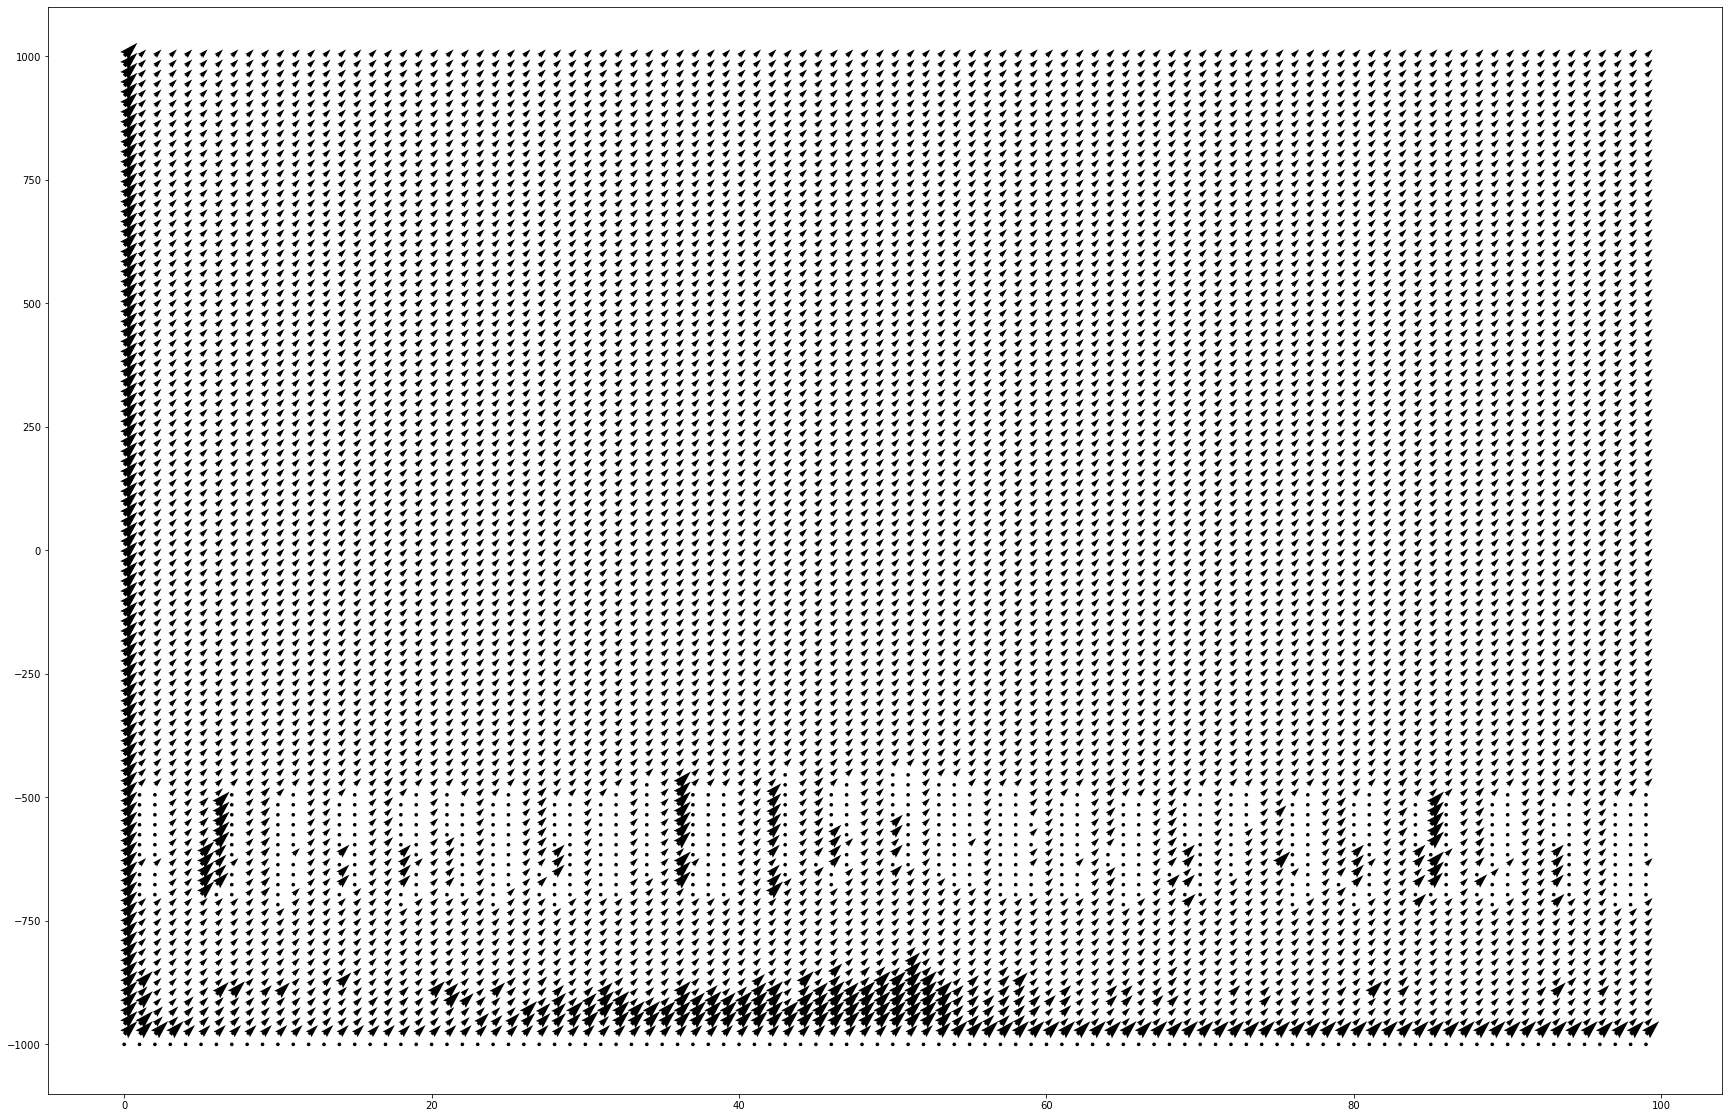

In [35]:
plt.figure(figsize = (30, 20))
plt.quiver(range(0, int(T / dt)), y, phi_solved[2][:, 5, :], phi_solved[4][:, 5, :])